In [1]:
import numpy as np

In [2]:
import tensorflow as tf

In [3]:
import pandas as pd

In [4]:
np.random.seed(1)

In [5]:
tf.random.set_seed(1)

In [6]:
pd.options.mode.chained_assignment = None

In [7]:
tf.__version__

'2.3.1'

In [8]:
file_path='Dataset.csv'

In [9]:
df = pd.read_csv(file_path, parse_dates = ['Date'] )

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1986-01-03,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1986-01-06,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1986-01-07,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1986-01-08,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [11]:
df.shape

(8678, 7)

In [12]:
import seaborn as sns

In [13]:
from matplotlib.pylab import rcParams

In [14]:
import matplotlib.pyplot as plt

In [15]:
import plotly.io as pio

In [16]:
import plotly.graph_objs as go

In [17]:
sns.set(style = 'whitegrid', palette = 'muted')

In [18]:
rcParams['figure.figsize'] = 14, 8

In [19]:
pio.renderers.default = 'notebook_connected'

In [20]:
fig = go.Figure()

In [21]:
fig.add_trace(go.Scatter(x = df.Date, y = df.Close, mode = 'lines', name = 'Close'))

In [22]:
fig.update_layout(showlegend = True)

In [23]:
train_size = int(len(df) * 0.80)

In [24]:
test_size = len(df) - train_size

In [25]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [26]:
train.size

48594

In [27]:
test.size

12152

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()

In [30]:
scaler = scaler.fit(train[['Close']])

In [31]:
train['Close'] = scaler.transform(train[['Close']])

In [32]:
test['Close'] = scaler.transform(test[['Close']])

In [33]:
def create(X, y, time_steps):
    
    Xs, ys = [], [] 
    for i in range (len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

In [34]:
X_train, y_train = create(train[['Close']], train.Close, 30)

In [35]:
X_test, y_test = create(test[['Close']], test.Close, 30)

In [36]:
X_train.shape

(6912, 30, 1)

In [37]:
y_train.shape

(6912,)

In [38]:
X_test.shape

(1706, 30, 1)

In [39]:
y_test.shape

(1706,)

In [40]:
timesteps = X_train.shape[1]

In [41]:
n_features = X_train.shape[2]

In [42]:
from tensorflow.keras.models import Sequential

In [43]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [45]:
model = Sequential()

In [46]:
model.add(LSTM(128, input_shape = (timesteps, n_features)))

In [47]:
model.add(Dropout(0.2))

In [48]:
model.add(RepeatVector(timesteps))

In [49]:
model.add(LSTM(128, return_sequences = True))

In [50]:
model.add(Dropout(0.2))

In [51]:
model.add(TimeDistributed(Dense(n_features)))

In [52]:
model.compile(loss = 'mae', optimizer = 'adam')

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [54]:
ES = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min')

In [55]:
MC = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [56]:
callbacks_list = [ES, MC]

In [57]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.2, callbacks = callbacks_list, shuffle = False)

Epoch 1/100
173/173 [==============================] - 14s 83ms/step - loss: 0.1651 - val_loss: 0.1094
Epoch 2/100
173/173 [==============================] - 12s 70ms/step - loss: 0.1037 - val_loss: 0.0621
Epoch 3/100
173/173 [==============================] - 13s 73ms/step - loss: 0.0871 - val_loss: 0.0602
Epoch 4/100
173/173 [==============================] - 12s 72ms/step - loss: 0.0826 - val_loss: 0.0424
Epoch 5/100
173/173 [==============================] - 12s 71ms/step - loss: 0.0752 - val_loss: 0.0382
Epoch 6/100
173/173 [==============================] - 13s 76ms/step - loss: 0.0754 - val_loss: 0.0367
Epoch 7/100
173/173 [==============================] - 13s 72ms/step - loss: 0.0735 - val_loss: 0.0357
Epoch 8/100
173/173 [==============================] - 12s 72ms/step - loss: 0.0747 - val_loss: 0.0377
Epoch 9/100
173/173 [==============================] - 13s 73ms/step - loss: 0.0789 - val_loss: 0.0375
Epoch 10/100
173/173 [==============================] - 13s 73ms/step - l

In [58]:
from keras.models import load_model

In [59]:
model_saved = load_model('model.h5')

In [60]:
X_train_pred = model_saved.predict(X_train)

In [61]:
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis = 1), columns = ['Error'])

In [62]:
model_saved.evaluate(X_test, y_test)

54/54 [==============================] - 1s 26ms/step - loss: 0.2622


0.26224422454833984

c:\users\lenovo\desktop\anomaly_detection_s-and-p-500\venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

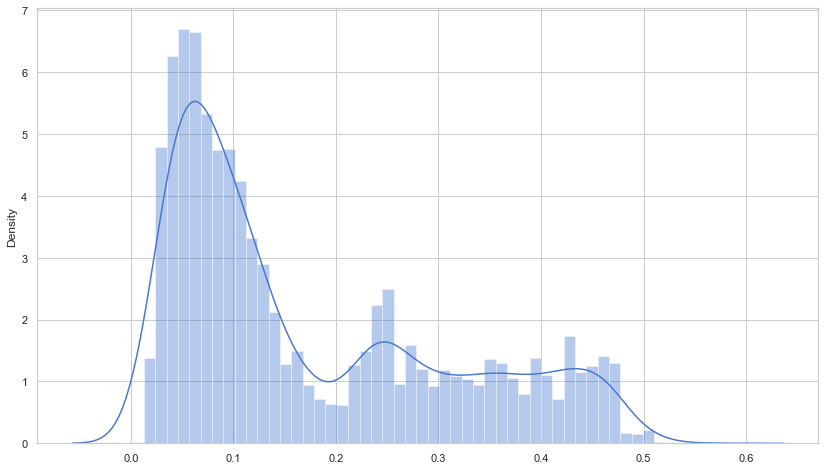

In [63]:
sns.distplot(train_mae_loss, bins = 50, kde = True)

In [64]:
threshold = 0.50 

In [65]:
X_test_pred = model_saved.predict(X_test)

In [66]:
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

In [67]:
test_score_df = pd.DataFrame(test[timesteps:])

In [68]:
test_score_df['loss'] = test_mae_loss

In [69]:
test_score_df['threshold'] = threshold

In [70]:
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

In [71]:
test_score_df['Close'] = test[timesteps:].Close

In [72]:
test_score_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly
6972,2013-08-27,1652.540039,1652.540039,1629.050049,1.758700,1630.479980,3219190000,0.086970,0.5,False
6973,2013-08-28,1630.250000,1641.180054,1627.469971,1.769141,1634.959961,2784010000,0.107798,0.5,False
6974,2013-08-29,1633.500000,1646.410034,1630.880005,1.776623,1638.170044,2527550000,0.117167,0.5,False
6975,2013-08-30,1638.890015,1640.079956,1628.050049,1.764503,1632.969971,2734300000,0.116790,0.5,False
6976,2013-09-03,1635.949951,1651.349976,1633.410034,1.780352,1639.770020,3731610000,0.118553,0.5,False


In [73]:
test_score_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly
8673,2020-06-01,3038.780029,3062.179932,3031.540039,5.080501,3055.729980,4673410000,0.260938,0.5,False
8674,2020-06-02,3064.780029,3081.070068,3051.639893,5.138978,3080.820068,5187230000,0.253887,0.5,False
8675,2020-06-03,3098.899902,3130.939941,3098.899902,5.236983,3122.870117,5989560000,0.233294,0.5,False
8676,2020-06-04,3111.560059,3128.909912,3090.409912,5.212464,3112.350098,6428130000,0.224978,0.5,False
8677,2020-06-05,3163.840088,3211.719971,3163.840088,5.402601,3193.929932,8617590000,0.223640,0.5,False


In [74]:
fig = go.Figure()

In [75]:
fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = test_score_df.loss, mode = 'lines', name = 'Test Loss')) 

In [76]:
fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = test_score_df.threshold, mode = 'lines', name = 'Threshold'))

In [77]:
anomalies = test_score_df[test_score_df.anomaly == True]

In [78]:
anomalies.head()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly
7475,2015-08-26,1872.750000,1943.089966,1872.750000,2.481280,1940.510010,5338250000,0.521574,0.5,True
8092,2018-02-07,2690.949951,2727.669922,2681.330078,4.208663,2681.659912,4626570000,0.542241,0.5,True
8093,2018-02-08,2685.010010,2685.270020,2580.560059,3.974057,2581.000000,5305440000,0.571357,0.5,True
8094,2018-02-09,2601.780029,2638.669922,2532.689941,4.063905,2619.550049,5680070000,0.659600,0.5,True
8095,2018-02-12,2636.750000,2672.610107,2622.449951,4.148858,2656.000000,4055790000,0.684672,0.5,True


In [79]:
fig = go.Figure()

In [80]:
fig.add_trace(go.Scatter(x = test[timesteps:].Date, y = scaler.inverse_transform(test[timesteps:].Close), mode = 'lines', name = 'Close Price')) 

In [81]:
fig.add_trace(go.Scatter(x = anomalies.Date, y = scaler.inverse_transform(anomalies.Close), mode = 'markers', name = 'Anomaly'))

In [95]:
pio.orca.config.executable ='C:/Users/Lenovo/AppData/Local/Programs/orca/orca.exe'

In [97]:
fig.write_image("./final_anomalies.png")